In [1]:
## Full backend analysis for the CREEDS and L1000 dataset 
import os
import pandas as pd
from pandas.compat import StringIO
import numpy as np
from numpy import loadtxt
import sys
import json
from pprint import pprint
import requests
import objectpath
import csv
import re
import matplotlib.pyplot as plt
import json, requests
from pprint import pprint
import itertools
import scipy
from scipy.spatial import distance
from sklearn.metrics.pairwise import pairwise_distances
from clustergrammer_widget import *
def get_geneset(df, indexer):
    df_ = df.loc[indexer, :]
    return list(df_[df_ == 1].index)

In [14]:

# load in the EMR Data (filtered > 200 in R code [Drug_diagnosis_test_code.R])
EMR_data = pd.read_csv("EMR_greater_200.csv")
## subset EMR data by the DOI and/or DrOI
EMR_data_df = pd.DataFrame(EMR_data)
#EMR_data
EMR_data_df.drop(EMR_data_df.columns[[0]], axis = 1, inplace = True) # remove the unecessary columns
#EMR_data_df

with open("L1000_CREEDS_Similar_Drug_output.txt", "r") as fd:
    similar_L1000_CREEDS_drugs = fd.read().splitlines()

EMR_drug_subset_df = EMR_data_df[EMR_data_df["Drug_Name"].isin(similar_L1000_CREEDS_drugs)]
total_overlap = pd.read_csv("combined_l1000_creeds.tsv", sep = "\t")

In [67]:
### multiply p values to get a mimic or reverse signature

total_overlap





,Unnamed: 0,AMLODIPINE BESYLATE_down,AMLODIPINE BESYLATE_up,ATRA_down,ATRA_up,Amlodipine_down,Amlodipine_up,Aripiprazole_down,Aripiprazole_up,Azathioprine_down,...,vinorelbine_down,vinorelbine_up,voriconazole_down,voriconazole_up,vorinostat_down,vorinostat_up,warfarin_down,warfarin_up,zolpidem_down,zolpidem_up
0,APECED - Autoimmune polyendocrinopathy-candidi...,0.125480,0.204159,0.070621,0.100465,0.125480,0.204159,0.001504,0.286292,0.061477,...,0.512608,0.002923,0.006525,1.826244e-02,0.160999,0.038356,0.357694,0.042395,0.010423,0.147124
1,APECED - Autoimmune polyendocrinopathy-candidi...,0.214672,0.106481,0.184230,0.273122,0.214672,0.106481,0.052672,0.164691,0.137270,...,0.202613,0.183170,0.048656,3.343949e-01,0.355294,0.070095,0.089927,0.181661,0.347183,0.365192
2,Acute Lung Injury_down,0.119084,0.093620,0.073525,0.108027,0.119084,0.093620,0.023995,0.108299,0.164369,...,0.025083,0.098338,0.049389,3.433953e-02,0.172667,0.073459,0.190930,0.276999,0.079418,0.031912
3,Acute Lung Injury_up,0.133285,0.151126,0.116405,0.072586,0.133285,0.151126,0.099044,0.075981,0.064232,...,0.122404,0.111453,0.000535,2.245882e-02,0.158063,0.037744,0.094075,0.041698,0.063502,0.064252
4,Acute arthritis_down,0.595164,0.323266,0.360164,0.486690,0.595164,0.323266,0.652078,0.265884,0.452925,...,0.303644,0.507253,0.753023,2.401342e-01,0.515654,0.346114,0.373219,0.227613,0.686202,0.484082
5,Acute arthritis_up,0.023859,0.064876,0.097625,0.037930,0.023859,0.064876,0.052801,0.067794,0.098964,...,0.017309,0.025184,0.000515,1.429607e-04,0.048204,0.027924,0.000309,0.105866,0.011418,0.034065
6,Adenovirus infection_down,0.348770,0.144185,0.275103,0.225466,0.348770,0.144185,0.508510,0.327183,0.438826,...,0.011588,0.598095,0.500258,5.263241e-01,0.347096,0.163996,0.315042,0.151870,0.413334,0.362308
7,Adenovirus infection_up,0.379314,0.124022,0.292234,0.244253,0.379314,0.124022,0.406914,0.086149,0.347925,...,0.128752,0.131483,0.502157,1.799858e-01,0.325263,0.232324,0.111395,0.291968,0.265777,0.594274
8,Alcohol poisoning_down,0.453702,0.365546,0.397542,0.381666,0.453702,0.365546,0.420633,0.433900,0.410048,...,0.461985,0.379012,0.246184,1.820373e-01,0.348075,0.472406,0.367285,0.386637,0.227534,0.418777
9,Alcohol poisoning_up,0.250537,0.154933,0.286625,0.228762,0.250537,0.154933,0.060771,0.219861,0.238152,...,0.228562,0.313585,0.262770,3.790892e-01,0.362553,0.138837,0.100297,0.361180,0.147984,0.335969


In [68]:
-total_overlap[((total_overlap['creeds_genes_direction'] == 'up') & (total_overlap['l1000_genes_direction'] == 'up'))].pivot_table(
    columns=['l1000_pert_desc', 'l1000_genes_direction'],
    index=['creeds_disease_name', 'creeds_genes_direction'],
    values='pvalue',
    aggfunc='mean',
)

KeyError: 'creeds_genes_direction'

In [ ]:
## example with warfarin
EMR_subset_example = EMR_drug_subset_df[EMR_drug_subset_df["Drug_Name"] == "WARFARIN"]

total_example = total_overlap.filter(like = "WARFARIN", axis = 1)
total_example.index = list(total_overlap["Unnamed: 0"])




In [55]:
## just look at hypertension and cardiac events

whitelist = ["hypertension",
             "hyperlipidemia",
             "renal",
             "kidney",
             "atrial",
             "diabetes",
             "anticoagulants",
             "coronary",
             "atherosclerosis",
             "congestive",
             "heart",
             "fib",
             "left",
             "right",
             "anemia"
            ]

total_example_subset = total_example[0:100]

In [63]:

def fuzzy_search(query, EMR_Drugs):
    return query.lower() in EMR_Drugs.lower()

def fuzzy_search_map(queryset):
    def fuzzy_search_map_inner(query):
        return any([fuzzy_search(queryset_item, query) for queryset_item in queryset])
    return fuzzy_search_map_inner

total_example_subset = total_example.loc[total_example.index.map(fuzzy_search_map(whitelist)), :]

In [64]:
total_example_subset.to_csv("warfarin_example.tsv", sep ="\t")

In [66]:
total_example_subset

,WARFARIN_down,WARFARIN_up
Arrhythmogenic Right Ventricular Cardiomyopathy_down,3.405537e-01,0.365238
Arrhythmogenic Right Ventricular Cardiomyopathy_up,4.464077e-01,0.263998
Diamond-Blackfan anemia_down,4.432615e-06,0.053799
Diamond-Blackfan anemia_up,2.819109e-11,0.004423
Erectile dysfunction associated with type 2 diabetes mellitus_down,1.277042e-01,0.681163
Erectile dysfunction associated with type 2 diabetes mellitus_up,1.123359e-04,0.012588
Heart Injury_down,2.247627e-01,0.598829
Heart Injury_up,5.485634e-03,0.115383
Hereditary gingival fibromatosis_down,5.093639e-05,0.000400
Hereditary gingival fibromatosis_up,2.032745e-02,0.070142


In [65]:

## clustergrammer implementation
# load data into new network instance and cluster
net = Network(clustergrammer_widget)

net.load_file("warfarin_example.tsv")
net.cluster()

# view the results as a widget
net.widget()

/Users/maayanlab/anaconda3/lib/python3.7/site-packages/clustergrammer_widget/clustergrammer/load_data.py:70: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  tmp_df['mat'] = pd.read_table(file_buffer, index_col=row_arr)


clustergrammer_widget(network='{"row_nodes": [{"name": "Arrhythmogenic Right Ventricular Cardiomyopathy_down",…

In [45]:
list(total_overlap["Unnamed: 0"])

['APECED - Autoimmune polyendocrinopathy-candidiasis-ectodermal dystrophy_down',
 'APECED - Autoimmune polyendocrinopathy-candidiasis-ectodermal dystrophy_up',
 'Acute Lung Injury_down',
 'Acute Lung Injury_up',
 'Acute arthritis_down',
 'Acute arthritis_up',
 'Adenovirus infection_down',
 'Adenovirus infection_up',
 'Alcohol poisoning_down',
 'Alcohol poisoning_up',
 'Alexander disease_down',
 'Alexander disease_up',
 "Alzheimer's disease_down",
 "Alzheimer's disease_up",
 'Anaplasmosis_down',
 'Anaplasmosis_up',
 'Arrhythmogenic Right Ventricular Cardiomyopathy_down',
 'Arrhythmogenic Right Ventricular Cardiomyopathy_up',
 "Barrett's esophagus_down",
 "Barrett's esophagus_up",
 'Bone fracture_down',
 'Bone fracture_up',
 'Burn_down',
 'Burn_up',
 'Carcinoma in situ of large intestine_down',
 'Carcinoma in situ of large intestine_up',
 'Carcinoma in situ of small intestine_down',
 'Carcinoma in situ of small intestine_up',
 'Cardiac Hypertrophy_down',
 'Cardiac Hypertrophy_up',
 'Card

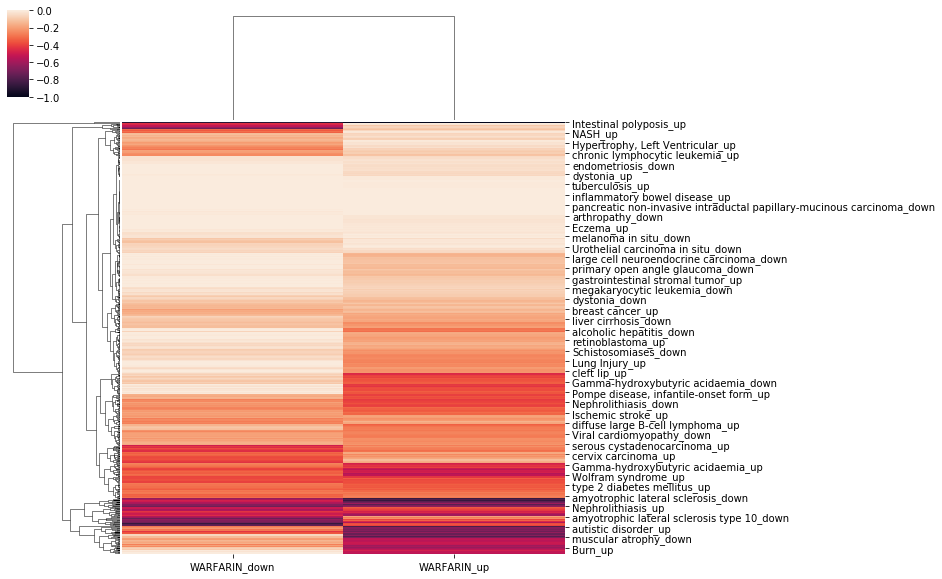

In [44]:
# plot example
import seaborn as sns
sns.clustermap(-total_example)


In [41]:
total_example

,WARFARIN_down,WARFARIN_up
APECED - Autoimmune polyendocrinopathy-candidiasis-ectodermal dystrophy_down,0.357694,0.042395
APECED - Autoimmune polyendocrinopathy-candidiasis-ectodermal dystrophy_up,0.089927,0.181661
Acute Lung Injury_down,0.190930,0.276999
Acute Lung Injury_up,0.094075,0.041698
Acute arthritis_down,0.373219,0.227613
Acute arthritis_up,0.000309,0.105866
Adenovirus infection_down,0.315042,0.151870
Adenovirus infection_up,0.111395,0.291968
Alcohol poisoning_down,0.367285,0.386637
Alcohol poisoning_up,0.100297,0.361180
